# Semantic segmentation
https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/

We will be using the ENet deep learning semantic segmentation architecture:
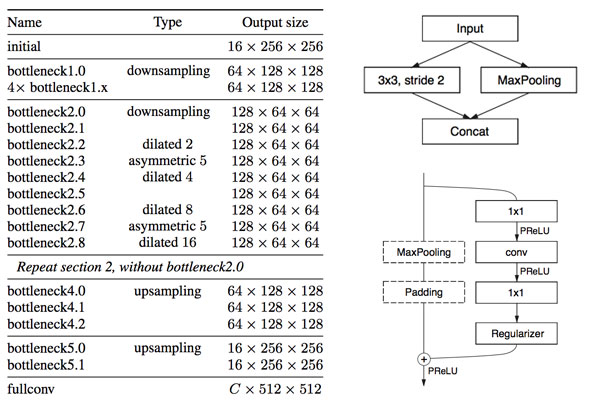

In [1]:
import numpy as np
import imutils
import time
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

## Settings

In [2]:
model_path = 'enet-cityscapes/enet-model.net' # Path to deep learning segmentation model
classes_path = 'enet-cityscapes/enet-classes.txt' # Path to .txt file containing class labels
image_path = 'images/example_04.png' # Path to input image
colours_path = 'enet-cityscapes/enet-colors.txt' # Path to .txt file containing colors for labels
width = 500 # Desired width (in pixels) of input image

## Initialization

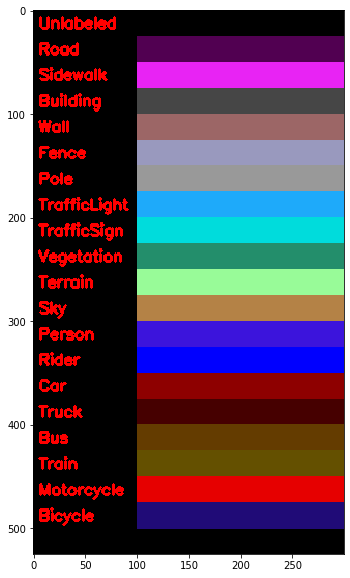

In [3]:
# Load our serialized model from disk
net = cv2.dnn.readNet(model_path)

# Load the class label names
CLASSES = open(classes_path).read().strip().split("\n")

# If a colours file was supplied, load it from disk
if colours_path:
    COLORS = open(colours_path).read().strip().split("\n")
    COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
    COLORS = np.array(COLORS, dtype="uint8")
    
# Otherwise, we need to randomly generate RGB colors for each class label
else:
    # Initialize a list of colors to represent each class label in the mask
    #(starting with 'black' for the background/unlabeled regions)
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(CLASSES) - 1, 3), dtype="uint8")
    COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")
    
# Initialize the legend visualization
legend = np.zeros(((len(CLASSES) * 25) + 25, 300, 3), dtype="uint8")

# Loop over the class names + colors
for (i, (className, color)) in enumerate(zip(CLASSES, COLORS)):
    # Draw the class name + color on the legend
    color = [int(c) for c in color]
    cv2.putText(legend, className, (5, (i * 25) + 17), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25), tuple(color), -1)
    
plt.imshow(cv2.cvtColor(legend, cv2.COLOR_BGR2RGB))

## Segmentation

In [4]:
# Load the input image, resize it, and construct a blob from it, but keeping mind mind that
# the original input image dimensions ENet was trained on was 1024x512
image = cv2.imread(image_path)
image = imutils.resize(image, width=width)
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (1024, 512), 0, swapRB=True, crop=False)

# Perform a forward pass using the segmentation model
net.setInput(blob)
start = time.time()
output = net.forward()
end = time.time()

# Show the amount of time inference took
print("Inference has taken {:.4f} seconds".format(end - start))

Inference has taken 0.1428 seconds


Text(0.5, 1.0, 'Segmentation')

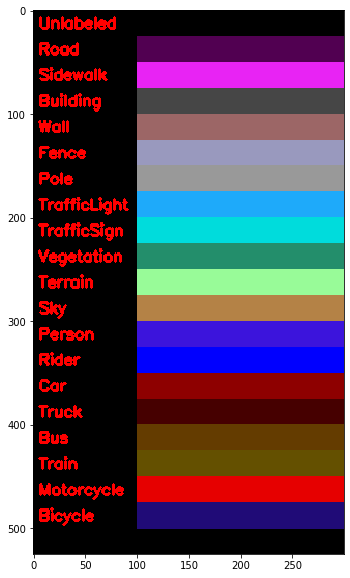

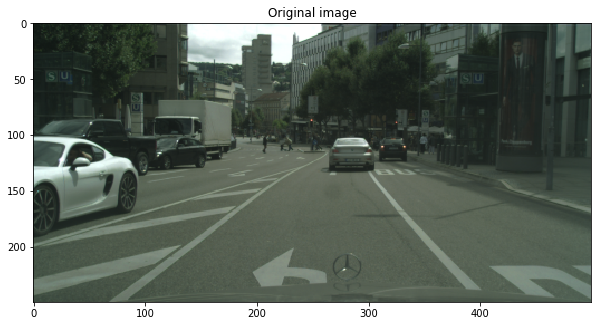

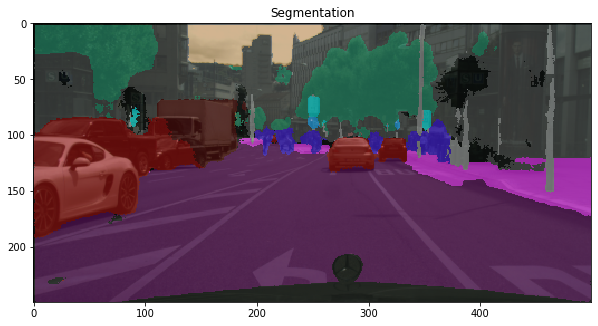

In [5]:
# Infer the total number of classes along with the spatial dimensions
# of the mask image via the shape of the output array
(numClasses, height, width) = output.shape[1:4]

# Our output class ID map will be num_classes x height x width in size, so we take the argmax to
# find the class label with the largest probability for each and every (x, y)-coordinate in the image
classMap = np.argmax(output[0], axis=0)

# Given the class ID map, we can map each of the class IDs to its corresponding colour
mask = COLORS[classMap]

# Resize the mask and class map such that its dimensions match the original size of the input
# image (we're not using the class map here for anything else but this is how you would resize
# it just in case you wanted to extract specific pixels/classes)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Perform a weighted combination of the input image with the mask to form an output visualization
output = ((0.4 * image) + (0.6 * mask)).astype("uint8")

# Show the input and output images
plt.imshow(cv2.cvtColor(legend, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.figure()
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Segmentation')

# Video segmentation

## Settings

In [6]:
video_path = 'videos/massachusetts.mp4' # Path to input video file
output_path = 'output/video_segmented.mp4'  # Path to output video file

In [7]:
# Initialize the video stream and pointer to output video file
vs = cv2.VideoCapture(video_path)
writer = None

# Try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("{} total frames in video".format(total))
    
# An error occurred while trying to determine the total
# number of frames in the video file
except:
    print("Could not determine # of frames in video")
    total = -1

4235 total frames in video


In [8]:
# Loop over frames from the video file stream
while True:
    # Read the next frame from the file
    (grabbed, frame) = vs.read()
    
    # If the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break
        
    # Construct a blob from the frame and perform a forward pass using the segmentation model
    frame = imutils.resize(frame, width=width)
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (1024, 512), 0, swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    output = net.forward()
    end = time.time()
    
    # Infer the total number of classes along with the spatial
    # dimensions of the mask image via the shape of the output array
    (numClasses, height, width) = output.shape[1:4]
    
    # Our output class ID map will be num_classes x height x width in size, so we take the argmax to
    # find the class label with the largest probability for each and every (x, y)-coordinate in the image
    classMap = np.argmax(output[0], axis=0)

    # Given the class ID map, we can map each of the class IDs to its corresponding colour
    mask = COLORS[classMap]

    # Resize the mask and class map such that its dimensions match the original size of the input
    # image (we're not using the class map here for anything else but this is how you would resize
    # it just in case you wanted to extract specific pixels/classes)
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    classMap = cv2.resize(classMap, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Perform a weighted combination of the input frame with the mask to form an output visualization
    output = ((0.3 * frame) + (0.7 * mask)).astype("uint8")
    
    # Check if the video writer is None
    if writer is None:
        # Initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(output_path, fourcc, 30, (output.shape[1], output.shape[0]), True)

        # Some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("Single frame has taken {:.4f} seconds".format(elap))
            print("Estimated total time: {:.4f}".format(elap * total))
    
    # Write the output frame to disk
    writer.write(output)
        
# Release the file pointers
writer.release()
vs.release()

Single frame has taken 0.1378 seconds
Estimated total time: 583.6021
